In [1]:
import scCube
from scCube import scCube
from scCube.visualization import *
from scCube.utils import *
from matplotlib.pyplot import rc_context
import pandas as pd
import scanpy as sc
import numpy as np
import warnings
import time
warnings.filterwarnings("ignore")

/slurm/home/yrd/fanlab/qianjingyang/.conda/envs/sccube/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
model = scCube()

In [3]:
# adata and model are downloaded from https://github.com/ZJUFanLab/scCube/blob/main/tutorial/statistics.md
sc_adata = sc.read_h5ad('demo_data/Tabula_Muris_TM_facs_Brain_Non_Myeloid_adata.h5ad')

In [4]:
sc_adata.obs['Cell_type'].value_counts()

oligodendrocyte                   1574
endothelial cell                   715
astrocyte                          432
neuron                             281
oligodendrocyte precursor cell     203
brain pericyte                     156
Bergmann glial cell                 40
Name: Cell_type, dtype: int64

In [5]:
# generate user-specified number of cells or cell types
generate_sc_meta, generate_sc_data = model.load_vae_and_generate_cell(
    sc_adata=sc_adata,
    celltype_key='Cell_type',
    cell_key='Cell',
    target_num={'oligodendrocyte': 2000, 'endothelial cell': 600, 'astrocyte': 500, 'neuron': 500, 'oligodendrocyte precursor cell': 100, 'brain pericyte': 100, 'Bergmann glial cell': 0},
    hidden_size=128,
    load_path='demo_data/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth',
    used_device='cuda:1')

generating by the targeted proportion of cell types...
loading model from demo_data/Tabula_Muris_TM_facs_Brain_Non_Myeloid_epoch10000.pth
vae loading done!


Generate Epoch: 1: 100%|██████████| 3800/3800 [00:00<00:00, 10290.80it/s]


generated done!
data have been prepared!


In [6]:
generate_sc_meta['Cell_type'].value_counts()

oligodendrocyte                   2000
endothelial cell                   600
astrocyte                          500
neuron                             500
oligodendrocyte precursor cell     100
brain pericyte                     100
Name: Cell_type, dtype: int64

In [7]:
sc.pp.highly_variable_genes(sc_adata, flavor="seurat_v3", n_top_genes=2000)
sc_adata = sc_adata[:, sc_adata.var.highly_variable]
sc.pp.scale(sc_adata, max_value=10)
sc.tl.pca(sc_adata, svd_solver='arpack')
sc.pp.neighbors(sc_adata)
sc.tl.umap(sc_adata)

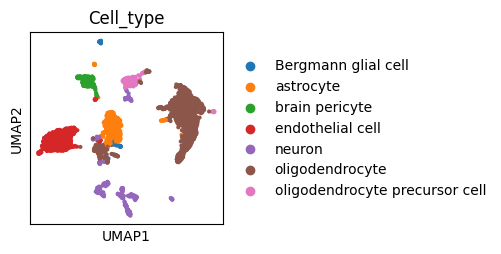

In [8]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata, color='Cell_type')

In [9]:
sc_adata_generate = model.pre_process(sc_data=generate_sc_data, 
                                      sc_meta=generate_sc_meta,
                                      is_normalized=True)

sc.pp.highly_variable_genes(sc_adata_generate, flavor="seurat_v3", n_top_genes=2000)
sc_adata_generate = sc_adata_generate[:, sc_adata_generate.var.highly_variable]
sc.pp.scale(sc_adata_generate, max_value=10)
sc.tl.pca(sc_adata_generate, svd_solver='arpack')
sc.pp.neighbors(sc_adata_generate)
sc.tl.umap(sc_adata_generate)

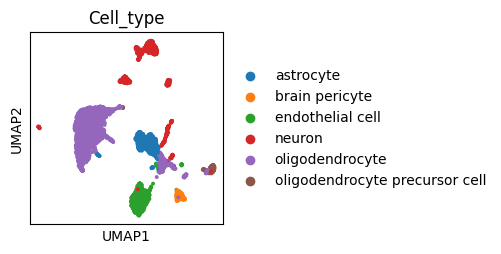

In [10]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(sc_adata_generate, color='Cell_type')

In [11]:
adata_concat = sc_adata.concatenate(sc_adata_generate, batch_categories=['real', 'generate'])
sc.tl.pca(adata_concat)
# sc.external.pp.bbknn(adata_concat, batch_key='batch')  # running bbknn 1.3.6
sc.pp.neighbors(adata_concat)
sc.tl.umap(adata_concat)

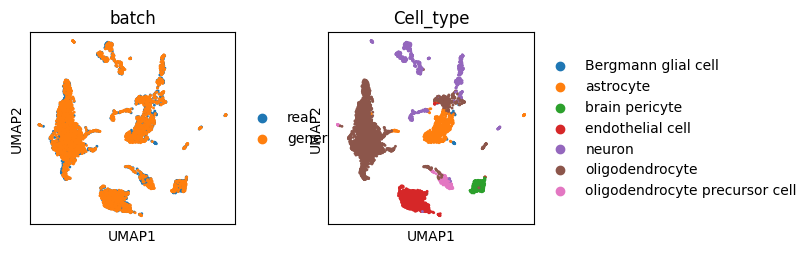

In [12]:
with rc_context({'figure.figsize': (2.5, 2.5)}):
    sc.pl.umap(adata_concat, color=['batch', 'Cell_type'])

In [14]:
# astrocyte, neuron have specified spatial patterns, other cell types follow uniform distributions
generate_sc_data, generate_sc_meta_new = model.generate_pattern_random(
    generate_sc_data=generate_sc_data,
    generate_sc_meta=generate_sc_meta,
    celltype_key='Cell_type',
    set_seed=True,
    seed=12345,
    spatial_cell_type=['astrocyte', 'neuron'],
    spatial_dim=2,
    spatial_size=30,
    delta=10,
    lamda=0.75,)

generating spatial coordinates of single cells...
generating spatial patterns of selected 2 cell types...


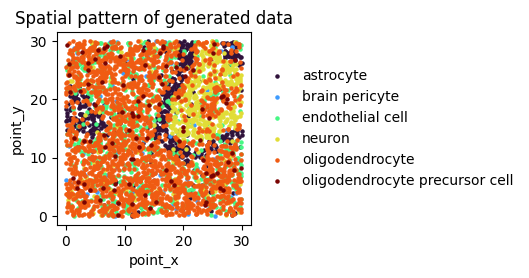

In [15]:
plot_spatial_pattern_scatter(
    obj=generate_sc_meta_new,
    figwidth=2.5,
    figheight=2.5,
    dim=2,
    x="point_x",
    y="point_y",
    label='Cell_type',
    colormap='turbo',
    size=5,
    alpha=1)

plt.show()

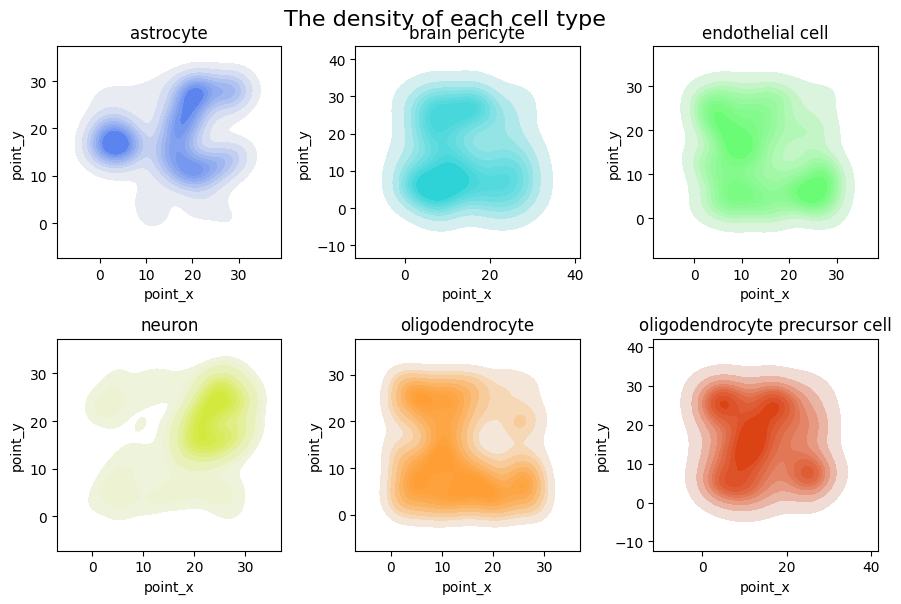

In [16]:
plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=9,
    figheight=6,
    x="point_x",
    y="point_y",
    show_celltype=None,
    label='Cell_type',
    colormap='turbo',
    fill=True)

plt.show()

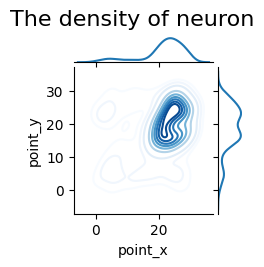

In [17]:
plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    show_celltype='neuron',
    label='Cell_type',
    colormap='Blues',
    fill=False)

plt.show()

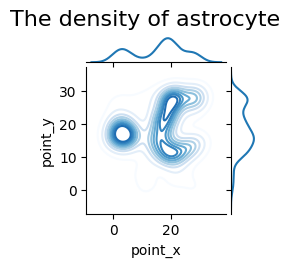

In [18]:
plot_spatial_pattern_density(
    obj=generate_sc_meta_new,
    figwidth=5,
    figheight=2.5,
    x="point_x",
    y="point_y",
    show_celltype='astrocyte',
    label='Cell_type',
    colormap='Blues',
    fill=False)

plt.show()

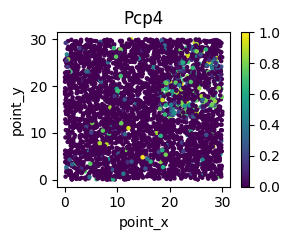

In [19]:
# Pcp4 -- neuron; Slc6a11 -- astrocyte
plot_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=2,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Pcp4",
    colormap='viridis',
    size=5,
    alpha=1
)

plt.show()

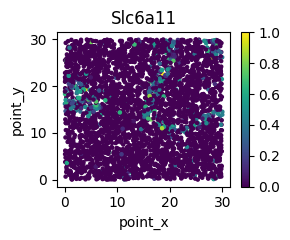

In [20]:
plot_gene_scatter(
    data=generate_sc_data,
    obj=generate_sc_meta_new,
    figwidth=3,
    figheight=2.5,
    dim=2,
    label='Cell',
    normalize=True,
    x="point_x",
    y="point_y",
    show_gene="Slc6a11",
    colormap='viridis',
    size=5,
    alpha=1
)

plt.show()